In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.stats import linregress
from scipy.stats import norm
from operator import itemgetter
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('data.csv')
df.head()

,Name,Age,Overall,Potential,Value,Wage,International Reputation,Weak Foot,Skill Moves,Position,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,L. Messi,31,94,94,€110.5M,€565K,5.0,4.0,4.0,RF,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,Cristiano Ronaldo,33,94,94,€77M,€405K,5.0,4.0,5.0,ST,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,Neymar Jr,26,92,93,€118.5M,€290K,5.0,5.0,5.0,LW,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,De Gea,27,91,93,€72M,€260K,4.0,3.0,1.0,GK,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,K. De Bruyne,27,91,92,€102M,€355K,4.0,5.0,4.0,RCM,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


# Data Sanitization

Some columns were removed in Microsoft Excel that were trivially unrelated (e.g. photos, country of origin, preferred foot). 

Before going any further, we must:
1. Turn values/wages to floats
2. Divide goalkeepers and other players (They have different related scores)
3. Calculate position scores
4. Relate/Combine value and wage. The response variable for this study is some mix between the value and the wage, the formula for which we need to figure out.

In [3]:
# 1
def priceToFloat(price):
    price = price[1:]
    try:
        price = float(price)
    except ValueError:
        price = float(price[:-1]) * (1000000 if price[-1] == 'M' else 1000 if price[-1] == 'K' else 1)
    return price
df['Value'] = df['Value'].apply(lambda x: priceToFloat(x))
df['Wage'] = df['Wage'].apply(lambda x: priceToFloat(x))

In [4]:
# 2
goalies_df = df[df['Position'] == 'GK'].dropna(axis=1)
players_df = df[df['Position'] != 'GK'].dropna()

In [5]:
# 3
def calculateScore(equation):
    return sum(map(int,(equation).split('+')))
for column in range(10,36):
    players_df[players_df.columns[column]] = players_df[players_df.columns[column]].apply(lambda x: calculateScore(x))

Pearson correlation coefficient: 0.8584417232332492


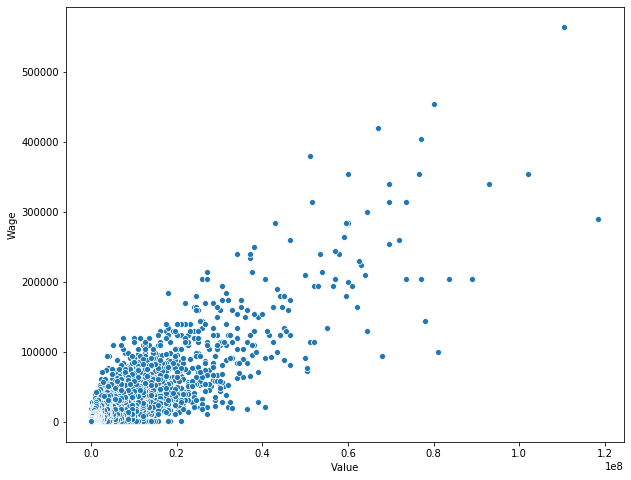

In [15]:
# 4
plt.figure(figsize = (10, 8))
sns.scatterplot(data=df, x="Value", y="Wage")
print('Pearson correlation coefficient: ' + str(df['Value'].corr(df['Wage'], method="pearson")))

From the above, we can see that there is collinearity between wages and their value. In context, value is the price for which it would cost to _buy_ them, and wage is the price to _keep_ them (like a salary). Wage has an extra variable of time to find worth, warranting questions of whether or not they'll be better in the near future, and how many years they still have to play. Thankfully, these parameters are taken care of with the _age_ and _potential_ columns, so there is no need to forecast that, and it would just result in more collinearity with the aforementioned columns. We will drop wage and use value as the response variable.

In [17]:
players_df.drop('Wage', axis=1)
goalies_df.drop('Wage', axis=1)

,Name,Age,Overall,Potential,Value,International Reputation,Weak Foot,Skill Moves,Position,Crossing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
3,De Gea,27,91,93,72000000.0,4.0,3.0,1.0,GK,17.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
9,J. Oblak,25,90,93,68000000.0,3.0,3.0,1.0,GK,13.0,...,11.0,70.0,27.0,12.0,18.0,86.0,92.0,78.0,88.0,89.0
18,M. ter Stegen,26,89,92,58000000.0,3.0,4.0,1.0,GK,15.0,...,25.0,69.0,25.0,13.0,10.0,87.0,85.0,88.0,85.0,90.0
19,T. Courtois,26,89,90,53500000.0,4.0,2.0,1.0,GK,14.0,...,27.0,66.0,20.0,18.0,16.0,85.0,91.0,72.0,86.0,88.0
22,M. Neuer,32,89,89,38000000.0,5.0,4.0,1.0,GK,15.0,...,47.0,70.0,17.0,10.0,11.0,90.0,86.0,91.0,87.0,87.0
37,H. Lloris,31,88,88,36000000.0,4.0,1.0,1.0,GK,13.0,...,40.0,65.0,29.0,10.0,18.0,88.0,84.0,68.0,83.0,92.0
40,S. Handanovič,33,88,88,30000000.0,3.0,2.0,1.0,GK,12.0,...,23.0,69.0,25.0,10.0,13.0,87.0,86.0,69.0,89.0,89.0
41,G. Buffon,40,88,88,4000000.0,4.0,2.0,1.0,GK,13.0,...,22.0,70.0,13.0,11.0,11.0,88.0,87.0,74.0,90.0,83.0
46,K. Navas,31,87,87,30500000.0,3.0,3.0,1.0,GK,11.0,...,25.0,67.0,28.0,14.0,14.0,90.0,81.0,75.0,82.0,90.0
57,Ederson,24,86,90,41500000.0,2.0,3.0,1.0,GK,20.0,...,17.0,70.0,28.0,15.0,8.0,85.0,80.0,91.0,82.0,87.0
